# Comparaison PySpark & Pandas Scikit Learn : Classification des crimes à San Fransisco

Lien de la compétition Kaggle: https://www.kaggle.com/c/sf-crime

## Importation des premiers modules.


In [2]:
# Formatage et Nettoyage des données
import os
import os.path as osp
import re
import time
import tqdm
import copy
from datetime import datetime
# Outil pour étude classique
import numpy as np
import pandas as pd
# Outil pour la visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.style.use('ggplot')
# Outil pour la classification avec scikit-learn
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizerSKL
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LogisticRegressionSKL
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifierSKL
# Outil pour l'analyse de texte NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Findspark
import findspark
findspark.init()
# Outil pour l'analyse avec PySpark
import pyspark
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import udf,col
from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Definition et initialisation du Spark Context

In [3]:
sc = pyspark.SparkContext("local[*]", "Spark Context 1")
sc

<SparkContext master=local[*] appName=Spark Context 1>

## 1. Importation des données

Il s'agit ici d'importer nos données.
Pour l'étude en PySpark :
 + Créer la base distribuée à partir du fichier csv.
 + Créer les features
 + Créer le dataframe spark correspondant.
 
Concernant l'étude avec les outils classiques:
 + Créer le DataFrame Pandas à partir du fichier csv.
 + Créer les features
 + Créer le dataframe Pandas pour les prédiction.

In [4]:
PATH_DATA = '../../../all/'

In [5]:
# Création de la base distribuée avec PySpark
spark = SparkSession.builder.getOrCreate()
df_spark = spark.read.csv(osp.join(PATH_DATA, 'train.csv'), header=True)

In [6]:
# Création du DataFrame avec Pandas
df_pandas = pd.read_csv(osp.join(PATH_DATA, 'train.csv'))

In [7]:
rows, columns = df_pandas.shape
print('Number of rows   :', rows)
print('Number of columns:', columns)

df_pandas.info()

Number of rows   : 878049
Number of columns: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [8]:
df_pandas.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [9]:
# Vérification du dataframe obtenu : son schema 
df_spark.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

## DateTime Features

In [10]:
toTimestamp = udf(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), TimestampType())
getYear = udf(lambda x: x.year, IntegerType())
getMonth = udf(lambda x: x.month, IntegerType())
getWeek = udf(lambda x: (x.day - 1) // 7 + 1, IntegerType())
getisDay = udf(lambda x: 1 if 6 <= x.hour < 18 else 0, IntegerType())
getisNight = udf(lambda x: 0 if x==1 else 1, IntegerType())
isWeekend = udf(lambda x: 1 if x== 'Saturday' or x== 'Sunday' else 0, IntegerType())
isWeekDay = udf(lambda x: 0 if x==1 else 1, IntegerType())
getDayOfWeek = udf(lambda x: x.weekday(), IntegerType())

In [11]:
def creation_datetime_features_pyspark(df):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    time_then = time.time()
    dataframe = df.withColumn('Dates', toTimestamp(df.Dates))
    dataframe = dataframe.withColumn('Year', getYear(dataframe.Dates))
    dataframe = dataframe.withColumn('Month', getMonth(dataframe.Dates))
    dataframe = dataframe.withColumn('Week', getWeek(dataframe.Dates))
    dataframe = dataframe.withColumn('isDay', getisDay(dataframe.Dates))
    dataframe = dataframe.withColumn('DayOfWeek', getDayOfWeek(dataframe.Dates))
    dataframe = dataframe.withColumn('isNight', getisNight(dataframe.isDay))
    dataframe = dataframe.withColumn('isWeekend', isWeekend(dataframe.DayOfWeek))
    dataframe = dataframe.withColumn('isWeekDay', isWeekDay(dataframe.isWeekend))    
    time_now = time.time()
    return dataframe, round(time_now - time_then, 1)

def creation_datetime_features_pandas(df, copy=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    if copy:
        dataframe = df.copy()
    else:
        dataframe = df    
    time_then = time.time()
    dataframe['Dates_format'] =  pd.to_datetime(dataframe['Dates'], format='%Y-%m-%d %H:%M:%S')
    dataframe['Year'] = dataframe['Dates_format'].apply(lambda x: x.year)
    dataframe['Month'] = dataframe['Dates_format'].apply(lambda x: x.month)
    dataframe['Week'] = dataframe['Dates_format'].apply(lambda x: (x.day - 1)// 7 + 1)
    dataframe['isDay'] = dataframe['Dates_format'].apply(lambda x: 1 if 6 <= x.hour < 18 else 0)
    dataframe['isNight'] = dataframe['isDay'].apply(lambda x: 1 if x == 0 else 0)
    dataframe['isWeekend'] = dataframe['DayOfWeek'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
    dataframe['isWeekDay'] = dataframe['isWeekend'].apply(lambda x: 1 if x == 0 else 0)
    le = preprocessing.LabelEncoder()
    dataframe['DayOfWeek_label'] = le.fit_transform(dataframe['DayOfWeek'])
    time_now = time.time()
    return dataframe, round(time_now - time_then, 1)

def plot_datetime_features(dataframe, dataframe_spark, percentages, title='Evolution_datetime_features.png'):
    list_times_spark, list_times_pandas = [], []
    n_rows = dataframe.shape[0]
    for ratio in percentages:
        dataframe_bis = dataframe[: int(ratio * rows)]
        dataframe_spark_bis = dataframe_spark.limit(int(ratio * rows))
        list_times_spark.append(creation_datetime_features_pyspark(dataframe_spark_bis)[1])
        list_times_pandas.append(creation_datetime_features_pandas(dataframe_bis)[1])
    plt.figure(figsize=(10, 10))
    plt.plot(percentages, list_times_spark, label='PySpark')
    plt.plot(percentages, list_times_pandas, label='Pandas/Sk-Learn')
    plt.title("Evolution du temps avec la taille de l'échantillon")
    plt.xlabel("Pourcentage de l'échantillon utilisé")
    plt.ylabel("Temps (s)")
    plt.legend(loc='best')
    plt.savefig(title)

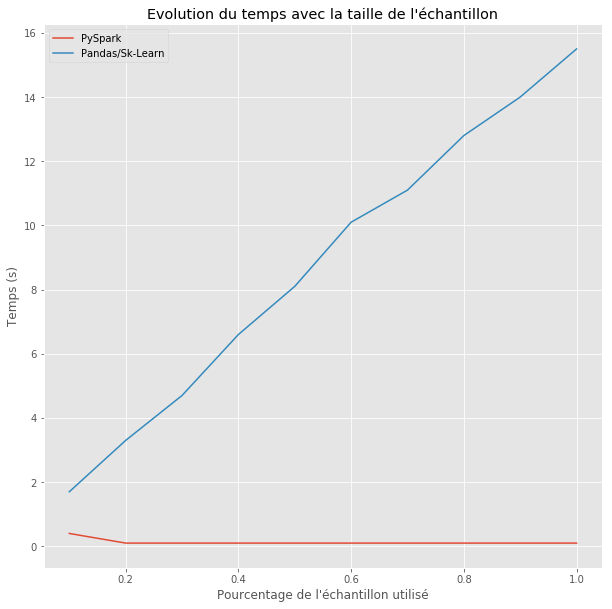

In [12]:
plot_datetime_features(df_pandas, df_spark, np.linspace(0.1, 1, 10), title='Evolution_datetime_features.png')

In [13]:
df_spark = creation_datetime_features_pyspark(df_spark)[0]
df_pandas = creation_datetime_features_pandas(df_pandas, copy=False)[0]

## NLP Features

In [14]:
regexTokenizer = RegexTokenizer(inputCol="Descript", outputCol="words", pattern="\\W")
sr_nltk = nltk.corpus.stopwords.words('english')
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(sr_nltk)
lemmatize = udf(lambda x: [nltk.stem.WordNetLemmatizer().lemmatize(w) for w in x], ArrayType(StringType()))
stemming = udf(lambda x: [nltk.stem.SnowballStemmer('english').stem(w) for w in x], ArrayType(StringType()))

In [15]:
def clean_txt(txt, stop_words=sr_nltk):
    words = word_tokenize(txt)
    filtered = [w for w in words if w not in stop_words]
    stemmed = [nltk.stem.SnowballStemmer('english').stem(w) for w in filtered]
    return words, filtered, stemmed

In [16]:
def creation_NLP_features_pyspark(df):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    time_then = time.time()
    dataframe = regexTokenizer.transform(df)
    dataframe = stopwordsRemover.transform(dataframe)
    dataframe = dataframe.withColumn('stemmed', stemming(dataframe.filtered))
    time_now = time.time()
    return dataframe, round(time_now - time_then, 1)

def creation_NLP_features_pandas(df, cop=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    if cop:
        dataframe = df.copy()
    else:
        dataframe = df    
    time_then = time.time()
    dataframe['stemmed'] = dataframe.Descript.apply(lambda x: clean_txt(x)[2])
    time_now = time.time()
    return dataframe, round(time_now - time_then, 1)

def plot_NLP_features(dataframe, dataframe_spark, percentages, title='Evolution_NLP_features.png'):
    list_times_spark, list_times_pandas = [], []
    n_rows = dataframe.shape[0]
    for ratio in percentages:
        dataframe_bis = dataframe[: int(ratio * rows)]
        dataframe_spark_bis = dataframe_spark.limit(int(ratio * rows))
        list_times_spark.append(creation_NLP_features_pyspark(dataframe_spark_bis)[1])
        list_times_pandas.append(creation_NLP_features_pandas(dataframe_bis)[1])
    plt.figure(figsize=(10, 10))
    plt.plot(percentages, list_times_spark, label='PySpark')
    plt.plot(percentages, list_times_pandas, label='Pandas/Sk-Learn')
    plt.title("Evolution du temps avec la taille de l'échantillon")
    plt.xlabel("Pourcentage de l'échantillon utilisé")
    plt.ylabel("Temps (s)")
    plt.legend(loc='best')
    plt.savefig(title)

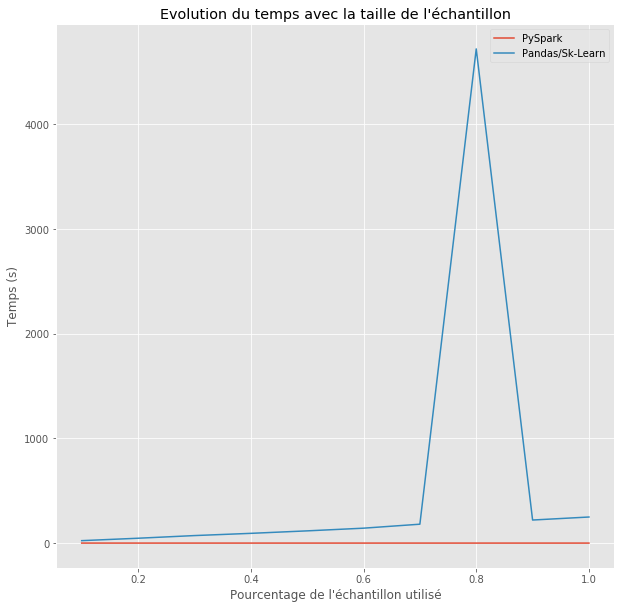

In [17]:
plot_NLP_features(df_pandas, df_spark, np.linspace(0.1, 1, 10), title='Evolution_NLP_features.png')

In [18]:
df_spark = creation_NLP_features_pyspark(df_spark)[0]
df_pandas = creation_NLP_features_pandas(df_pandas, cop=False)[0]

## TF-IDF Vector

In [19]:
hashing_tf = HashingTF(inputCol="stemmed", outputCol='tf', numFeatures=10000)
idf = IDF(inputCol=hashing_tf.getOutputCol(), outputCol="tfidf", minDocFreq=5)
countVectors = CountVectorizer(inputCol="stemmed", outputCol="countvector", vocabSize=10000, minDF=5)

In [20]:
def creation_TFIDF_features_pyspark(df):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""

    time_then = time.time()
    pipeline = Pipeline(stages=[hashing_tf, idf])
    pipelineFit = pipeline.fit(df)
    dataframe_idf = pipelineFit.transform(df)
    time_now = time.time()
    return dataframe_idf, round(time_now - time_then, 1)

def creation_TFIDF_features_pandas(df, cop=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    if cop:
        dataframe = df.copy()
    else:
        dataframe = df    
    time_then = time.time()
    tfidfModel = TfidfVectorizer()
    tfidf_array = tfidfModel.fit_transform(dataframe['stemmed'].apply(lambda x: " ".join(x)).values).toarray()
    time_now = time.time()
    return tfidf_array, round(time_now - time_then, 1)

def plot_TFIDF_features(dataframe, dataframe_spark, percentages, title='Evolution_TFIDF_features.png'):
    list_times_spark, list_times_pandas = [], []
    n_rows = dataframe.shape[0]
    for ratio in percentages:
        dataframe_bis = dataframe[: int(ratio * rows)]
        dataframe_spark_bis = dataframe_spark.limit(int(ratio * rows))
        list_times_spark.append(creation_TFIDF_features_pyspark(dataframe_spark_bis)[1])
        list_times_pandas.append(creation_TFIDF_features_pandas(dataframe_bis)[1])
    plt.figure(figsize=(10, 10))
    plt.plot(percentages, list_times_spark, label='PySpark')
    plt.plot(percentages, list_times_pandas, label='Pandas/Sk-Learn')
    plt.title("Evolution du temps avec la taille de l'échantillon")
    plt.xlabel("Pourcentage de l'échantillon utilisé")
    plt.ylabel("Temps (s)")
    plt.legend(loc='best')
    plt.savefig(title)

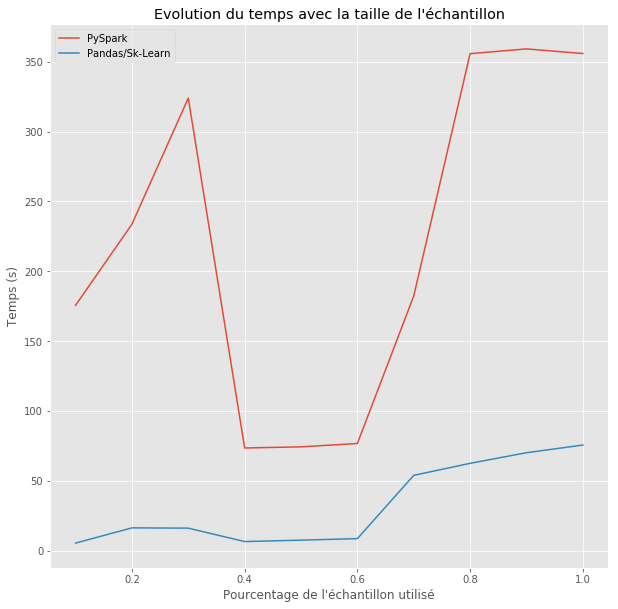

In [21]:
plot_TFIDF_features(df_pandas, df_spark, np.linspace(0.1, 1, 10), title='Evolution_TFIDF_features.png')

In [22]:
df_spark = creation_TFIDF_features_pyspark(df_spark)[0]
TFIDF_Matrix = creation_TFIDF_features_pandas(df_pandas, cop=False)[0]

## Count Vector

In [22]:
def creation_vectorcount_features_pyspark(df):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    time_then = time.time()
    dataframe = countVectors.fit(df).transform(df)
    time_now = time.time()
    return dataframe, round(time_now - time_then, 1)

def creation_vectorcount_features_pandas(df, cop=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    if cop:
        dataframe = df.copy()
    else:
        dataframe = df    
    time_then = time.time()
    countModel = CountVectorizerSKL()
    countvector = countModel.fit_transform(dataframe['stemmed'].apply(lambda x: " ".join(x)).values).toarray()
    time_now = time.time()
    return countvector, round(time_now - time_then, 1)

def plot_vectorcount_features(dataframe, dataframe_spark, percentages, title='Evolution_CountVector_features.png'):
    list_times_spark, list_times_pandas = [], []
    n_rows = dataframe.shape[0]
    for ratio in percentages:
        dataframe_bis = dataframe[: int(ratio * rows)]
        dataframe_spark_bis = dataframe_spark.limit(int(ratio * rows))
        list_times_spark.append(creation_vectorcount_features_pyspark(dataframe_spark_bis)[1])
        list_times_pandas.append(creation_vectorcount_features_pandas(dataframe_bis)[1])
    plt.figure(figsize=(10, 10))
    plt.plot(percentages, list_times_spark, label='PySpark')
    plt.plot(percentages, list_times_pandas, label='Pandas/Sk-Learn')
    plt.title("Evolution du temps avec la taille de l'échantillon")
    plt.xlabel("Pourcentage de l'échantillon utilisé")
    plt.ylabel("Temps (s)")
    plt.legend(loc='best')
    plt.savefig(title)

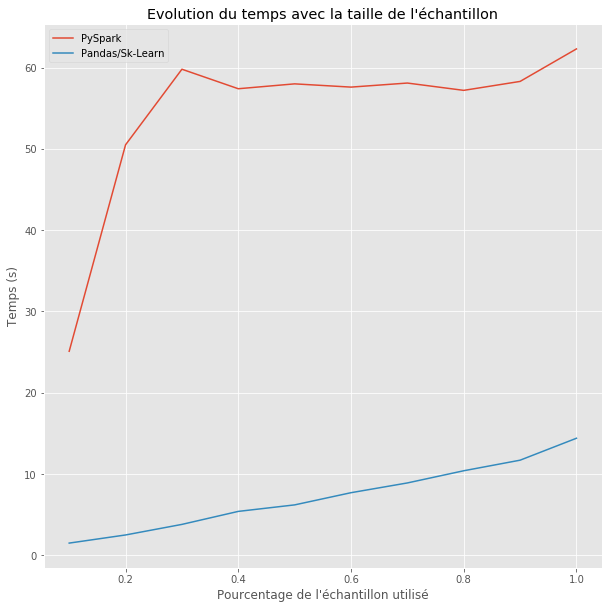

In [23]:
plot_vectorcount_features(df_pandas, df_spark, np.linspace(0.1, 1, 10), title='Evolution_CountVector_features.png')

In [24]:
df_spark = creation_vectorcount_features_pyspark(df_spark)[0]
VectorCountMatrix = creation_vectorcount_features_pandas(df_pandas, cop=False)[0]

## Label Encoding

In [25]:
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label")
district_stringIdx = StringIndexer(inputCol = "PdDistrict", outputCol = "PdDistrictLabel")
resolution_stringIdx = StringIndexer(inputCol = "Resolution", outputCol = "ResolutionLabel")
le = preprocessing.LabelEncoder()

In [26]:
def encoding_pyspark(df):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    time_then = time.time()
    dataframe = label_stringIdx.fit(df).transform(df)
    dataframe = district_stringIdx.fit(dataframe).transform(dataframe)
    dataframe = resolution_stringIdx.fit(dataframe).transform(dataframe)
    time_now = time.time()
    return dataframe, round(time_now - time_then, 1)

def encoding_pandas(df, cop=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    if cop:
        dataframe = df.copy()
    else:
        dataframe = df    
    time_then = time.time()
    dataframe['label'] = le.fit_transform(dataframe['Category'])
    dataframe['DayOfWeek'] = le.fit_transform(dataframe['DayOfWeek'])
    dataframe['ResolutionLabel'] = le.fit_transform(dataframe['Resolution'])
    time_now = time.time()
    return dataframe, round(time_now - time_then, 1)

def plot_encoding(dataframe, dataframe_spark, percentages, title='Evolution_encoding_features.png'):
    list_times_spark, list_times_pandas = [], []
    n_rows = dataframe.shape[0]
    for ratio in percentages:
        dataframe_bis = dataframe[: int(ratio * rows)]
        dataframe_spark_bis = dataframe_spark.limit(int(ratio * rows))
        list_times_spark.append(encoding_pyspark(dataframe_spark_bis)[1])
        list_times_pandas.append(encoding_pandas(dataframe_bis)[1])
    plt.figure(figsize=(10, 10))
    plt.plot(percentages, list_times_spark, label='PySpark')
    plt.plot(percentages, list_times_pandas, label='Pandas/Sk-Learn')
    plt.title("Evolution du temps avec la taille de l'échantillon")
    plt.xlabel("Pourcentage de l'échantillon utilisé")
    plt.ylabel("Temps (s)")
    plt.legend(loc='best')
    plt.savefig(title)

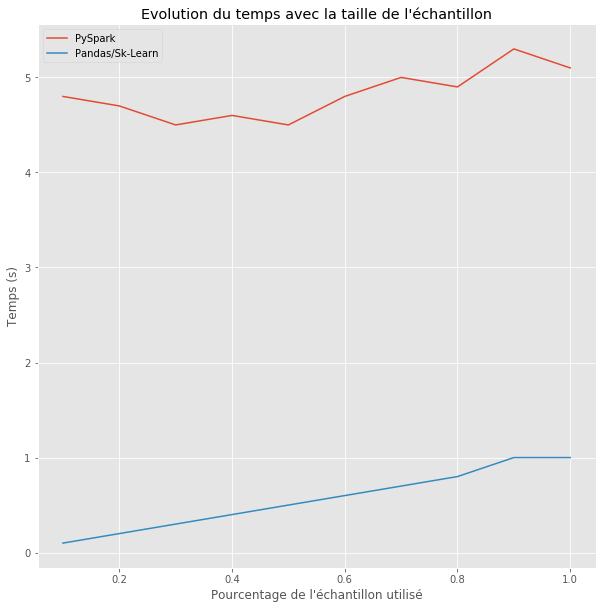

In [27]:
plot_encoding(df_pandas, df_spark, np.linspace(0.1, 1, 10), title='Evolution_encoding_features.png')

In [28]:
df_spark = encoding_pyspark(df_spark)[0]
df_pandas = encoding_pandas(df_pandas, cop=False)[0]

## Construction du DataFrame d'apprentissage

In [23]:
feature_list = ['Year', 'Month', 'Week', 'isDay', 'isNight','DayOfWeek', 'isWeekend', 'isWeekDay', 'ResolutionLabel']

In [ ]:
assembler = VectorAssembler(inputCols=feature_list+['tfidf'], outputCol="features")
df_spark_final_tfidf = assembler.transform(df_spark)
df_spark_final_tfidf = df_spark_final_tfidf.select(['features']+['label'])
df_spark_final_tfidf.show(5)

In [ ]:
tfidf_df = pd.DataFrame(TFIDF_Matrix)
df_pandas_final_tfidf = pd.concat([tfidf_df, df_pandas[feature_list+['label']]], axis=1)
df_pandas_final_tfidf.head(5)

In [32]:
assembler = VectorAssembler(inputCols=feature_list+['countvector'], outputCol="features")
df_spark_final_vectorcount = assembler.transform(df_spark)
df_spark_final_vectorcount = df_spark_final_vectorcount.select(['features']+['label'])
df_spark_final_vectorcount.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(694,[0,1,2,4,5,7...|  7.0|
|(694,[0,1,2,4,5,7...|  1.0|
|(694,[0,1,2,4,5,7...|  1.0|
|(694,[0,1,2,4,5,7...|  0.0|
|(694,[0,1,2,4,5,7...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [33]:
vectorcount_df = pd.DataFrame(VectorCountMatrix)
df_pandas_final_vectorcount = pd.concat([vectorcount_df, df_pandas[feature_list+['label']]], axis=1)
df_pandas_final_vectorcount.head(5)

,0,1,2,3,4,5,6,7,8,9,...,Year,Month,Week,isDay,isNight,DayOfWeek,isWeekend,isWeekDay,ResolutionLabel,label
0,0,0,0,0,0,0,0,0,0,0,...,2015,5,2,0,1,6,0,1,0,37
1,0,0,0,0,0,0,0,0,0,0,...,2015,5,2,0,1,6,0,1,0,21
2,0,0,0,0,0,0,0,0,0,0,...,2015,5,2,0,1,6,0,1,0,21
3,0,0,0,0,0,0,0,0,0,0,...,2015,5,2,0,1,6,0,1,11,16
4,0,0,0,0,0,0,0,0,0,0,...,2015,5,2,0,1,6,0,1,11,16


## Regression logistique

In [34]:
# Regression Logistique 
def logreg_pyspark(df, cop=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    #if cop:
    #    _schema = copy.deepcopy(df.schema)
    #    dataframe = df.rdd.zipWithIndex().toDF(_schema)
    #else:
    #    dataframe = df
    (trainingData, testData) = df.randomSplit([0.7, 0.3], seed = 100)
    lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
    time_then = time.time()
    lrModel = lr.fit(df)
    predictionslr = lrModel.transform(testData)
    time_now = time.time()
    return predictionslr, round(time_now - time_then, 1)

def logreg_pandas(df, cop=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    if cop:
        dataframe = df.copy()
    else:
        dataframe = df  
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['label'], test_size=0.3, random_state=42)
    time_then = time.time()
    clf = LogisticRegressionSKL(C=0.3, random_state=0, 
                                solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit((X_train, y_train)
    pred = clf.predict(X_test)
    time_now = time.time()
    return pred, round(time_now - time_then, 1)

def plot_logreg(dataframe, dataframe_spark, percentages, title='Evolution_logreg_features.png'):
    list_times_spark, list_times_pandas = [], []
    n_rows = dataframe.shape[0]
    for ratio in percentages:
        dataframe_bis = dataframe[: int(ratio * rows)]
        dataframe_spark_bis = dataframe_spark.limit(int(ratio * rows))
        list_times_spark.append(logreg_pyspark(dataframe_spark_bis)[1])
        list_times_pandas.append(logreg_pandas(dataframe_bis)[1])
    plt.figure(figsize=(10, 10))
    plt.plot(percentages, list_times_spark, label='PySpark')
    plt.plot(percentages, list_times_pandas, label='Pandas/Sk-Learn')
    plt.title("Evolution du temps avec la taille de l'échantillon")
    plt.xlabel("Pourcentage de l'échantillon utilisé")
    plt.ylabel("Temps (s)")
    plt.legend(loc='best')
    plt.savefig(title)

### Score Regression Logistique avec TF-IDF

/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs faile

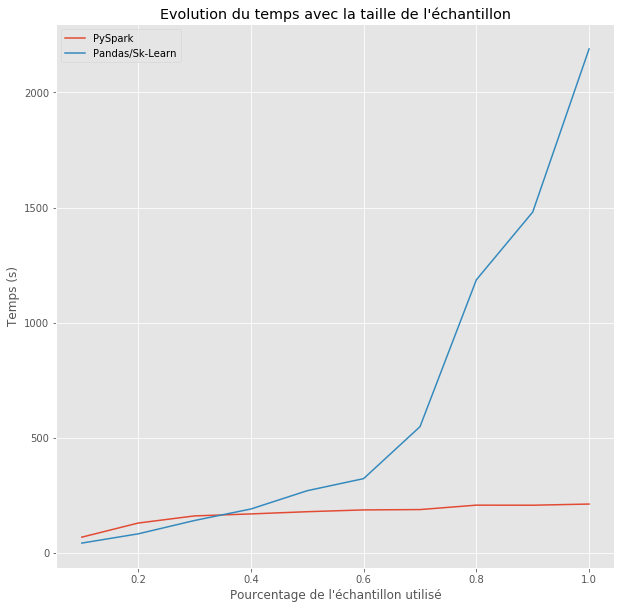

In [51]:
plot_logreg(df_pandas_final_tfidf, df_spark_final_tfidf, np.linspace(0.1, 1, 10), title='Evolution_logreg_TFIDF_features.png')

In [52]:
(trainingData, testData) = df_spark_final_tfidf.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
#lr.setLabelCol("label").setFeaturesCol("tfidf")
lrModel = lr.fit(df_spark_final_tfidf)

predictionslr = lrModel.transform(testData)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictionslr)

0.9159177489387338

## Score Regression Logistique avec CountVectorizer

/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aymanebenayada/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs faile

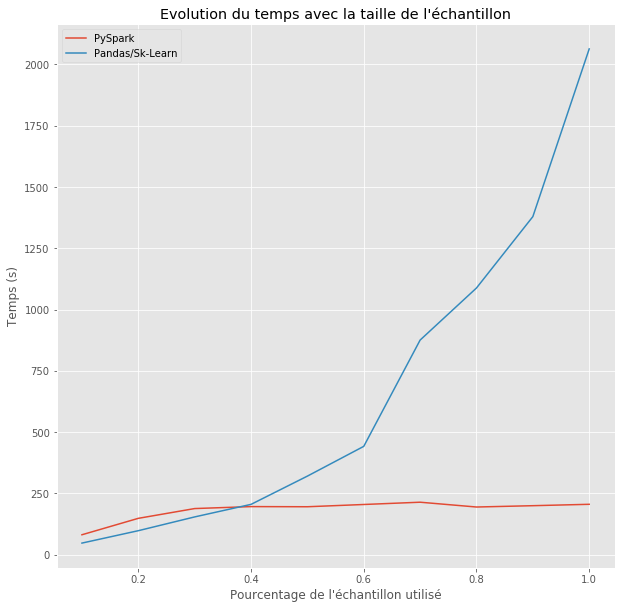

In [35]:
plot_logreg(df_pandas_final_vectorcount, df_spark_final_vectorcount, np.linspace(0.1, 1, 10), title='Evolution_logreg_vectorcount_features.png')

In [ ]:
(trainingData, testData) = df_spark_final_vectorcount.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictionslr = lrModel.transform(testData)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictionslr)

## Random Forests

In [ ]:
# Regression Logistique 
def rf_pyspark(df, cop=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    #if cop:
    #    _schema = copy.deepcopy(df.schema)
    #    dataframe = df.rdd.zipWithIndex().toDF(_schema)
    #else:
    #    dataframe = df
    (trainingData, testData) = df.randomSplit([0.7, 0.3], seed = 100)
    rf = RandomForestClassifier(numTrees = 100, maxDepth = 4, maxBins = 32)
    time_then = time.time()
    rfModel = rf.fit(trainingData)
    predictionsrf = rfModel.transform(testData)
    time_now = time.time()
    return predictionsrf, round(time_now - time_then, 1)

def rf_pandas(df, cop=True):
    """Input: Initial pandas dataframe
    Output: Dataframe with additionnal columns containing datetime features"""
    if cop:
        dataframe = df.copy()
    else:
        dataframe = df  
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['label'], test_size=0.3, random_state=42)
    time_then = time.time()
    clf = RandomForestClassifierSKL(n_estimators=100, max_depth=4, n_jobs=-1).fit(X_train, y_train)
    pred = clf.predict(X_test)
    time_now = time.time()
    return pred, round(time_now - time_then, 1)

def plot_rf(dataframe, dataframe_spark, percentages, title='Evolution_rf_features.png'):
    list_times_spark, list_times_pandas = [], []
    n_rows = dataframe.shape[0]
    for ratio in percentages:
        dataframe_bis = dataframe[: int(ratio * rows)]
        dataframe_spark_bis = dataframe_spark.limit(int(ratio * rows))
        list_times_spark.append(rf_pyspark(dataframe_spark_bis)[1])
        list_times_pandas.append(rf_pandas(dataframe_bis)[1])
    plt.figure(figsize=(10, 10))
    plt.plot(percentages, list_times_spark, label='PySpark')
    plt.plot(percentages, list_times_pandas, label='Pandas/Sk-Learn')
    plt.title("Evolution du temps avec la taille de l'échantillon")
    plt.xlabel("Pourcentage de l'échantillon utilisé")
    plt.ylabel("Temps (s)")
    plt.legend(loc='best')
    plt.savefig(title)

### Score Random Forest avec TF-IDF

In [ ]:
plot_rf(df_pandas_final_tfidf, df_spark_final_tfidf, np.linspace(0.1, 1, 10), title='Evolution_rf_TFIDF_features.png')

In [ ]:
(trainingData, testData) = df_spark_final_tfidf.randomSplit([0.7, 0.3], seed = 100)
rf = RandomForestClassifier(numTrees = 100, maxDepth = 4, maxBins = 32)
rfModel = rf.fit(trainingData)
predictionsrf = rfModel.transform(testData)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictionsrf)

### Score Random Forest avec CountVectorizer

In [ ]:
plot_rf(df_pandas_final_vectorcount, df_spark_final_vectorcount, np.linspace(0.1, 1, 10), title='Evolution_rf_vectorcount_features.png')

In [ ]:
(trainingData, testData) = df_spark_final_vectorcount.randomSplit([0.7, 0.3], seed = 100)
rf = RandomForestClassifier(numTrees = 100, maxDepth = 4, maxBins = 32)
rfModel = rf.fit(trainingData)
predictionsrf = rfModel.transform(testData)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictionsrf)